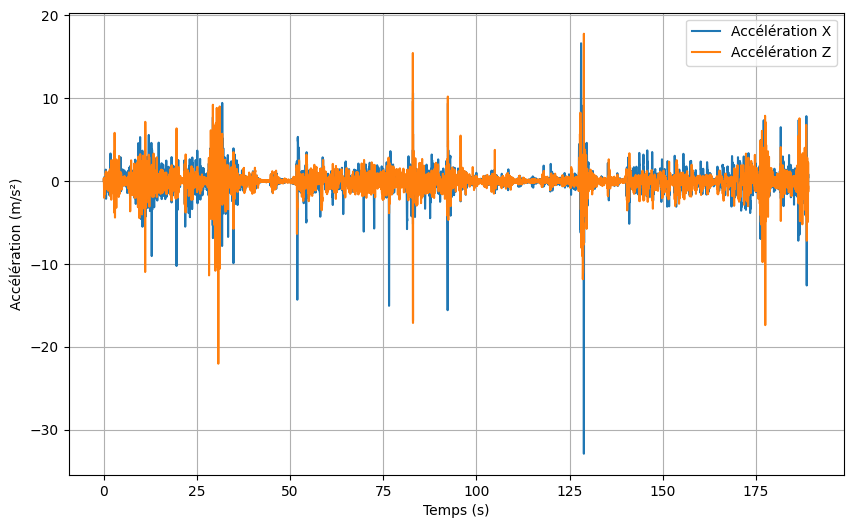

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Chargement des données
données_original = pd.read_csv('Raw Data.csv')

# Préparation des données
données = données_original.set_index('Time (s)')
del données['Absolute acceleration (m/s^2)']
del données['Linear Acceleration y (m/s^2)']


plt.figure(figsize=(10, 6))
plt.plot(données.index, données['Linear Acceleration x (m/s^2)'], label="Accélération X")
plt.plot(données.index, données['Linear Acceleration z (m/s^2)'], label="Accélération Z")
plt.xlabel('Temps (s)')
plt.ylabel('Accélération (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
def filtre_et_sens(f):
    for i in range(0, len(données.iloc[:, 0])):
        données.iloc[i, 0] = - données.iloc[i, 0]
        données.iloc[i, 1] = - données.iloc[i, 1]
        for j in range(2):
            element = données.iloc[i, j]
            if element < f and element > -f:
                données.iloc[i, j] = 0

filtre_et_sens(0.3)

In [4]:
données_montee = données.loc[51:94.5]
données_chute = données.loc[127.3:130.3]

# constructeur_fig(données_montee).show()
# constructeur_fig(données_chute).show()

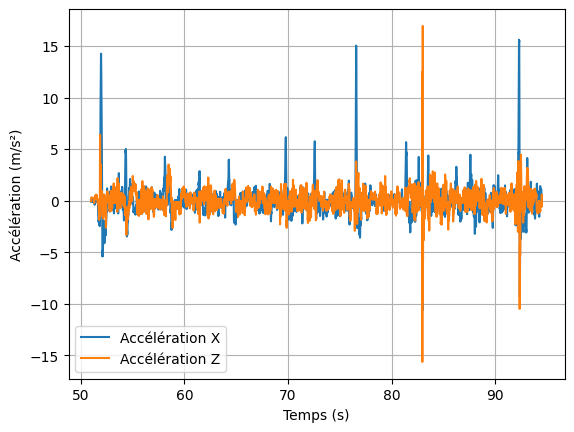

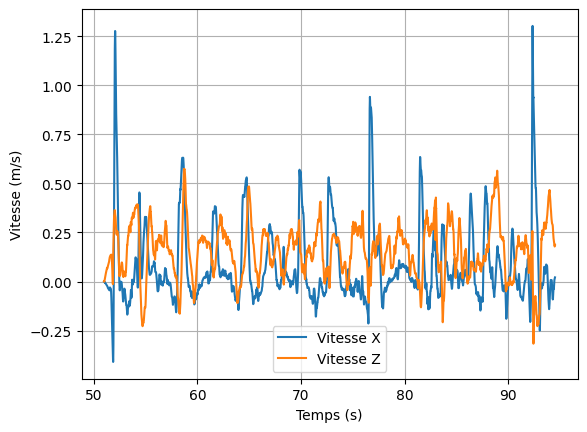

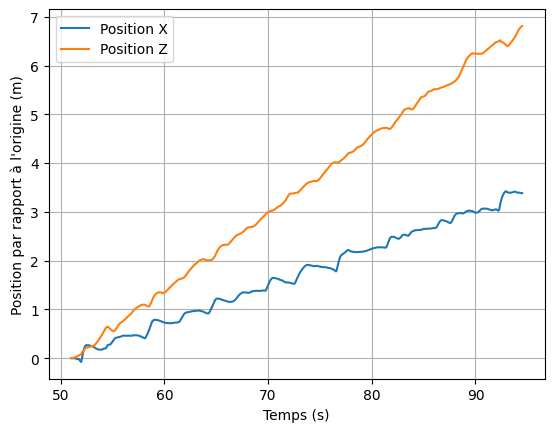

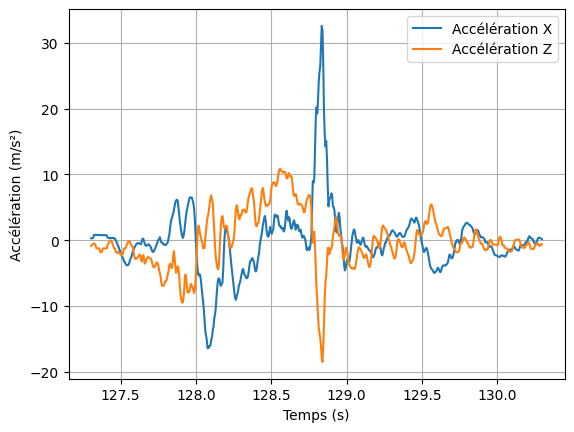

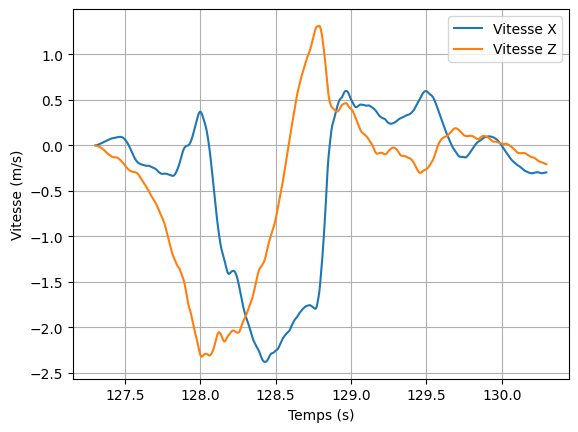

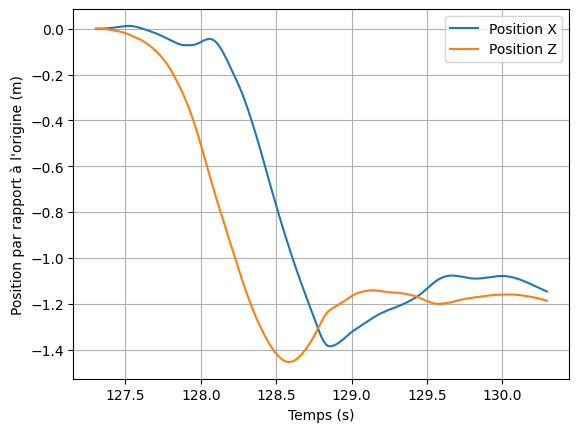

In [5]:
from scipy.integrate import cumulative_trapezoid
from scipy.signal import butter, filtfilt

dx = np.mean(np.diff(données.index))

def filtre_passe_haut(data, cutoff=0.2, fs=1/dx, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

def filtrage(données):

    acceleration_x = filtre_passe_haut(données['Linear Acceleration x (m/s^2)'].values)
    acceleration_z = filtre_passe_haut(données['Linear Acceleration z (m/s^2)'].values)

    vitesse_x = cumulative_trapezoid(acceleration_x, dx=dx, initial=0)
    vitesse_z = cumulative_trapezoid(acceleration_z, dx=dx, initial=0)

    position_x = cumulative_trapezoid(vitesse_x, dx=dx, initial=0)
    position_z = cumulative_trapezoid(vitesse_z, dx=dx, initial=0)

    plt.plot(données.index, acceleration_x, label="Accélération X")
    plt.plot(données.index, acceleration_z, label="Accélération Z")
    plt.xlabel('Temps (s)')
    plt.ylabel('Accélération (m/s²)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # fig_acceleration = go.Figure()
    # fig_acceleration.add_trace(go.Scatter(x=données.index, y=acceleration_x, name='acceleration_x'))
    # fig_acceleration.add_trace(go.Scatter(x=données.index, y=acceleration_y, name='acceleration_y'))
    # fig_acceleration.add_trace(go.Scatter(x=données.index, y=acceleration_z, name='acceleration_z'))

    plt.plot(données.index, vitesse_x, label="Vitesse X")
    plt.plot(données.index, vitesse_z, label="Vitesse Z")
    plt.xlabel('Temps (s)')
    plt.ylabel('Vitesse (m/s)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # fig_vitesse = go.Figure()
    # fig_vitesse.add_trace(go.Scatter(x=données.index, y=vitesse_x, name='vitesse_x'))
    # fig_vitesse.add_trace(go.Scatter(x=données.index, y=vitesse_y, name='vitesse_y'))
    # fig_vitesse.add_trace(go.Scatter(x=données.index, y=vitesse_z, name='vitesse_z'))

    plt.plot(données.index, position_x, label="Position X")
    plt.plot(données.index, position_z, label="Position Z")
    plt.xlabel('Temps (s)')
    plt.ylabel("Position par rapport à l'origine (m)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # fig_position = go.Figure()
    # fig_position.add_trace(go.Scatter(x=données.index, y=position_x, name='position_x'))
    # fig_position.add_trace(go.Scatter(x=données.index, y=position_y, name='position_y'))
    # fig_position.add_trace(go.Scatter(x=données.index, y=position_z, name='position_z'))

    # fig_acceleration.show()
    # fig_vitesse.show()
    # fig_position.show()

    return [acceleration_x, acceleration_z, vitesse_x, vitesse_z, position_x, position_z]

données_f_montee = filtrage(données_montee)
données_f_chute = filtrage(données_chute)

In [6]:
def compris(x, a, b):
    return x >= a and x <= b

def escalade_effective():
    temps_pause = 0
    temps_total = 0

    vitesse_x = données_f_montee[2]
    vitesse_z = données_f_montee[3]
    for i in range(len(vitesse_x)):
        if compris(vitesse_x[i], -0.1, 0.1) and compris(vitesse_z[i], -0.1, 0.1):
            temps_pause+= dx
        
        temps_total+= dx
    
    return [temps_total - temps_pause, temps_total]

valeurs_escalade_effective = escalade_effective()
print(valeurs_escalade_effective[0])
print(valeurs_escalade_effective[1])
print(valeurs_escalade_effective[0]/valeurs_escalade_effective[1])

35.28686652789199
43.49933490285647
0.8112047369619623


In [7]:
def vitesse_max_montée():
    vitesse_max = 0

    vitesse_x = données_f_montee[2]
    vitesse_z = données_f_montee[3]
    for i in range(len(vitesse_x)):
        if np.sqrt(vitesse_x[i]**2 + vitesse_z[i]**2) > vitesse_max:
            vitesse_max = np.sqrt(vitesse_x[i]**2 + vitesse_z[i]**2)
    
    return vitesse_max

def vitesse_max_chute():
    vitesse_max = 0

    vitesse_x = données_f_chute[2]
    vitesse_z = données_f_chute[3]
    for i in range(len(vitesse_x)):
        if np.sqrt(vitesse_x[i]**2 + vitesse_z[i]**2) > vitesse_max:
            vitesse_max = np.sqrt(vitesse_x[i]**2 + vitesse_z[i]**2)
    
    return vitesse_max

print(vitesse_max_montée())
print(vitesse_max_chute())

1.3222164068933135
2.699153691967456
